# Tajima and Dawson

This notebook enables one to reproduce the simulations of T. Tajima and J. M. Dawson, "Laser Electron Accelerator." Phys. Rev. Lett. **43**, 267 (1979).

These are 1D simulations with a relativistic electromagnetic PIC code.

* $L_x = 512\Delta$
* $c = 5 v_e$
* $k_x = 2\pi / 15\Delta$
* number of electrons = 5120
* particle size = $1\Delta$

where:
* $\Delta$ is the unit spatial grid distance
* $v_e$ is the electron thermal speed

The following relations are kept fixed:
* $eE_0/m\omega = eB_0/m\omega = c$
* $L_t = \pi c/\omega_p$
* $p_0 = eE_0/\omega$
* $\omega = (\omega_p^2 + k_x^2c^2)^{1/2}$

where:
* $E_0$ and $B_0$ are the pump wave electric and magnetic field amplitudes
* $p_0$ is the corresponding amplitude for the momentum modulation


Cases are run for $c = [5, 7.25, 10, 14.7]\omega_p\Delta$.
* $E_y = E_0\sin k_x(x-x_0)$
* $B_z = B_0\sin k_x(x-x_0)$
* $p_y = p^{random}+p_0\cos k_x(x-x_0)$

"In this series of simulations, a run with larger $c$ means larger $\omega$, longer photon train $L_t$, and stronger $E_0$, since $\omega_p$ is taken to be constant."

OSIRIS simulations are done in normalized units. 

* Time:  $t' = t \omega_{p}$

* Frequency: $\omega' = \frac{\omega}{\omega_{p}}$ 

* Position: $\vec{x}' = \frac{\omega_{p}}{c} \vec{x}$  

* Momenta: $\vec{u}' = \frac{\vec{p}}{m_{e} c} = \frac{\vec{\gamma v}}{c} = \frac{\vec{u}} {c}$  

* Electric field: $\vec{E}' = e \frac{c / \omega_{p}}{m_{e} c^2} \vec{E}$  

* Magnetic field: $\vec{B}' = e \frac{c / \omega_{p}}{m_{e} c^2} \vec{B}$  


We will set a few variables:

* By definition in the article, $c = a\omega_p\Delta$ with $a=[5, 7.25, 10, 14.7]$
* Normalizations for OSIRIS will be set with $\omega_{p} = 1$ and $c = 1$.
* $v_e = 0.2c = 0.2a\omega_p\Delta$
* If $c$ is going to be temporarily variable, set $\Delta$ to be something specific: $\Delta = 0.2$
* $L_x = 512\Delta = 102.4$
* 5120 particles gives 10 particles per cell

In [12]:
# We first import necessary libraries

import sys
b= sys.path
sys.path=['/home/jovyan/analysis'] + b
import osiris
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from osh5vis import new_fig, osplot
from osh5io import read_h5
from osh5utils import fft
import glob
from ipywidgets import interact_manual,fixed,Layout
import ipywidgets as widgets
interact_calc=interact_manual.options(manual_name="Make New Input and Run")
import os
from osiris import tajima

#Define some functions for later

def plot_maxgamma_t(simdir):
    
    maxg, time = [], []
    for f in sorted(glob.glob(simdir + '/MS/PHA/p1x1/electrons/*.h5')):
        data = read_h5(f)
        ind = np.nonzero(data)
        maxg.append(np.sqrt(1+(data.axes[0][max(ind[0])])**2))
        time.append(data.run_attrs['TIME'])
    print('max gamma = ', max(maxg))
    
def newifile(iname='case0.txt', oname='case1.txt', uth=0.1, 
             a0=1.0, omega0=2.0, t_flat=3.14, t_rise=0, t_fall=0,
            nx_p=1024, xmax=102.4, ndump=1):

    with open(iname) as osdata:
        data = osdata.readlines()

    for i in range(len(data)):
        if 'uth(1:3)' in data[i]:
            data[i] = 'uth(1:3) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'uth_bnd(1:3,1,1)' in data[i]:
            data[i] = 'uth_bnd(1:3,1,1) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'uth_bnd(1:3,2,1)' in data[i]:
            data[i] = 'uth_bnd(1:3,2,1) = '+str(uth)+'d0 , '+str(uth)+'d0 , '+str(uth)+'d0,\n'
        if 'a0 =' in data[i] and 'omega0' not in data[i]:
            data[i] = 'a0 = '+str(a0)+',\n'
        if 'omega0 =' in data[i]:
            data[i] = 'omega0 = '+str(omega0)+',\n'
        if 't_flat =' in data[i]:
            data[i] = 't_flat = '+str(t_flat)+',\n'
        if 't_rise =' in data[i]:
            data[i] = 't_rise = '+str(t_rise)+',\n'
        if 't_fall =' in data[i]:
            data[i] = 't_fall = '+str(t_fall)+',\n'
        if 'nx_p(1:1) =' in data[i]:
            data[i] = 'nx_p(1:1) = '+str(nx_p)+',\n'
        if 'dt =' in data[i]:
            dt = (0.98 * xmax / nx_p)
            data[i] = 'dt = '+str(dt)+'e0'+',\n'
        if 'xmax(1:1) =' in data[i] and 'ps_xmax(1:1)' not in data[i]:
            data[i] = 'xmax(1:1) = '+str(xmax)+'e0,\n'
        if 'x(1:2,1) =' in data[i] and 'fx(1:2,1)' not in data[i]:
            data[i] = 'x(1:2,1) = 0.0, '+str(xmax)+',\n'
        if 'ndump =' in data[i]:
            data[i] = 'ndump = '+str(ndump)+',\n'

    with open(oname,'w') as f:
        for line in data:
            f.write(line)
    
    print('New file '+oname+' is written.')
    dirname = oname.strip('.txt')
    print('Running OSIRIS in directory '+dirname+'...')
    osiris.runosiris(rundir=dirname,inputfile=oname,print_out='yes')
    plot_maxgamma_t(dirname)
    print('Done')

### Run the canonical case from the paper.

In [5]:
dirname = 'case0'
osiris.runosiris(rundir=dirname,inputfile='case0.txt')

runosiris completed normally


Run the next cell to look at the results of the simulation. Click along the slider to see later timesteps. 

In [2]:
dirname = './case0'
tajima(rundir=dirname)

interactive(children=(IntSlider(value=0, description='file_no', max=1260, step=5), Output()), _dom_classes=('w…

In the next cell we try to replicate Figure 2a in the paper.

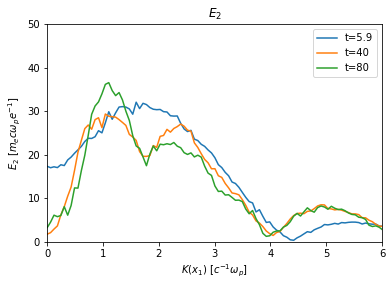

In [3]:
dirname = './case0'
plt.figure()
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000030.h5'))), xlim=[0, 6], ylim=[0, 50])
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000205.h5'))), xlim=[0, 6], ylim=[0, 50])
osplot(np.abs(fft(read_h5(dirname+'/MS/FLD/e2/e2-000410.h5'))), xlim=[0, 6], ylim=[0, 50])
plt.title('$E_2$')
plt.legend(['t=5.9', 't=40', 't=80'])
plt.show()

### Parameters to test for Figure 2

Now we want to run cases with different values of $c$ used in the paper. We need to find the corresponding OSIRIS input parameters.
1. Laser frequency:
$$\omega = (\omega_p^2 + k_x^2c^2)^{1/2}$$
$$\frac{\omega^2}{\omega_p^2} = 1 + a^2k_x^2\Delta^2$$
Since $k_x\Delta = \frac{2\pi}{15}$, we have 
$$\frac{\omega^2}{\omega_p^2} = 1 + a^2\left(\frac{2\pi}{15}\right)^2$$

2. Laser antenna:
$$a_0 = \frac{E_0}{\omega}$$
Since $E_0$ is kept to be $E_0 = \frac{m\omega c}{e}$, then 
$$a_0 = \frac{mc}{e}$$
For $m = e = 1$, 
$$a_0 = a\omega_p\Delta $$

3. Laser train length: 
$$L_t = \pi \frac{c}{\omega_p}$$
$$L_t = \pi a \Delta$$

In [14]:
def find_input_param(c_vec):
    dx = 0.2
    for i in c:
        ve = 0.2
        a0 = i*dx
        w = np.sqrt(1 + (i**2)*(2*np.pi/15)**2)
        Lt = i*np.pi*dx
        print('For c = {:5.2f}, v_e = {:4.2f}, a0 = {:4.2f}, w/wp = {:4.2f}, Lt = {:4.2f}'.format(i,ve,a0,w,Lt))
        
c = [5, 7.25, 10, 14.7]
find_input_param(c)
        
        

For c =  5.00, v_e = 0.20, a0 = 1.00, w/wp = 2.32, Lt = 3.14
For c =  7.25, v_e = 0.20, a0 = 1.45, w/wp = 3.20, Lt = 4.56
For c = 10.00, v_e = 0.20, a0 = 2.00, w/wp = 4.31, Lt = 6.28
For c = 14.70, v_e = 0.20, a0 = 2.94, w/wp = 6.24, Lt = 9.24


In the widget below, enter these parameters and a name for the output. When the button is clicked, the function will run OSIRIS and print the maximum electron energy achieved. The output is saved in a directory with the same name as the output text file. 

There is the option below to make advanced changes to the input deck but the default values will match the simulations in the paper.

In [13]:
style = {'description_width': '150px'}
layout = Layout(width='35%')

a = widgets.Text(value='case0.txt', description='Template Input File:',style=style,layout=layout)
b = widgets.Text(value='case1.txt', description='New Output File:',style=style,layout=layout)
c = widgets.BoundedFloatText(value=0.2, min=0.0, max=2.0, description='v_e/c:',style=style,layout=layout)
d = widgets.FloatText(value=1.0,description='a0:',style=style,layout=layout)
e = widgets.BoundedFloatText(value=2.0, min=0, max=10.5, description='omega0:',style=style,layout=layout)
f = widgets.BoundedFloatText(value=3.14, min=0, max=100, description='Lt:',style=style,layout=layout)
g = widgets.BoundedFloatText(value=0, min=0, max=100, description='t_rise:',style=style,layout=layout)
h = widgets.BoundedFloatText(value=0, min=0, max=100, description='t_fall:',style=style,layout=layout)
nx_pw = widgets.IntText(value=1024, description='nx_p:', style=style, layout=layout)
xmaxw = widgets.FloatText(value=102.4, description='xmax:', style=style, layout=layout)
ndumpw = widgets.IntText(value=1, description='ndump:', style=style, layout=layout)

interact_calc(newifile, iname=a,oname=b,uth=c,a0=d,omega0=e,t_flat=f, 
              t_rise=g, t_fall=h, nx_p=nx_pw, xmax=xmaxw, ndump=ndumpw);


interactive(children=(Text(value='case0.txt', description='Template Input File:', layout=Layout(width='35%'), …

In [15]:
dirname = './case1'
tajima(rundir=dirname)

interactive(children=(IntSlider(value=0, description='file_no', max=1225, step=5), Output()), _dom_classes=('w…